In [1]:
import json
import os
import mimetypes

import pandas as pd

from plot_from_dict import *

C:\Users\Florent\AppData\Local\Temp\ipykernel_15460\2103612586.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
%cd ..
%pwd

c:\Users\Florent\GNN\ML_research_seminar


c:\Users\Florent\anaconda3\envs\testenc\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'c:\\Users\\Florent\\GNN\\ML_research_seminar'

# I. Preparation of the data

In [3]:
list_dict = []

path_results = "./model/results/"

with os.scandir(path_results) as entries:

    for entry in entries:

        if entry.is_file() :

          name = entry.name

          if 'json' in mimetypes.guess_type(name)[0] :

            with open(f"{path_results}/{name}", 'r') as file:

              data = json.load(file)

            list_dict.append(data)

In [4]:
path_homophily = "./homophily/homophily_data.csv"

df_homophily = pd.read_csv(path_homophily)
df_homophily['Name_Dataset'] = df_homophily['Name_Dataset'].apply(lambda s : s.upper())
df_homophily.head()

,Name_Dataset,Size_dataset,Nb_class,Nb_features,Seed,Homophily_edge_train,Homophily_edge_test,Homophily_node_train,Homophily_node_test,Homophily_edge_insensitive_train,Homophily_edge_insensitive_test
0,MUTAG,188,2,7,12345,0.721,0.722,0.661,0.662,0.034,0.035
1,ENZYMES,600,6,3,12345,0.667,0.660,0.665,0.664,0.370,0.399
2,PROTEINS,1113,2,3,12345,0.657,0.654,0.652,0.648,0.372,0.367
3,PATTERN,10000,2,3,12345,0.333,0.333,0.333,0.333,0.000,0.000
4,CLUSTER,10000,6,7,12345,0.905,0.905,0.901,0.901,0.009,0.000


In [5]:
# adding the homophily values to the entries of each dictionnary of list_dict
for dic in list_dict :
  name_dataset = dic["dataset"]

  try :
    dic["homophily"] = df_homophily.loc[df_homophily['Name_Dataset'] == name_dataset, 'Homophily_edge_train'].values[0]
  except IndexError :
    dic["homophily"] = 0.

In [6]:
list_dict[0].keys()

dict_keys(['dataset', 'max_epochs', 'patience', 'lr', 'convolution_layer', 'global_pooling_layer', 'local_pooling_layer', 'alpha', 'batch_size', 'nb_parameters', 'mean_accuracy', 'std_accuracy', 'homophily'])

In [7]:
# creating a variable of pooling that takes into account the global and the local pooling
for dic in list_dict:
    dic["pooling"] = f"{dic['global_pooling_layer']}+{dic['local_pooling_layer']}"

# II. Scatter plot in 3D

In [8]:
# in order to have an interactive view for the following plots
%matplotlib widget

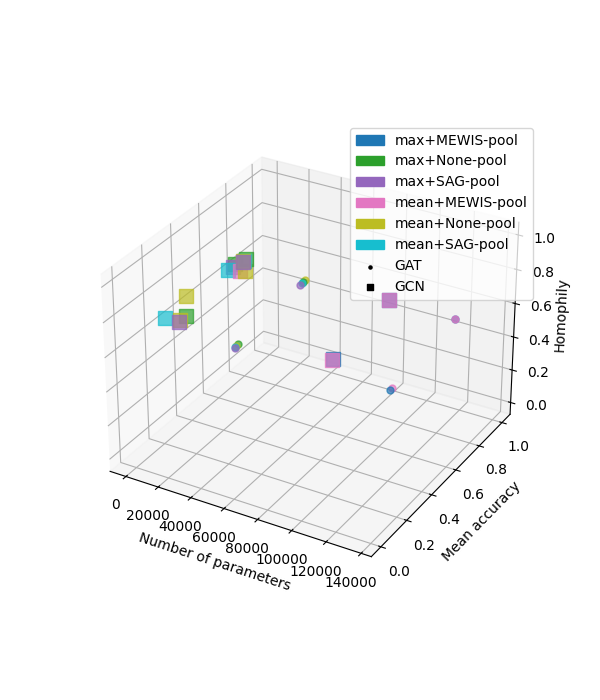

In [11]:
plot_from_dict(list_dict, (6,7), alpha=0.7, s=100)

# III. Pairplot

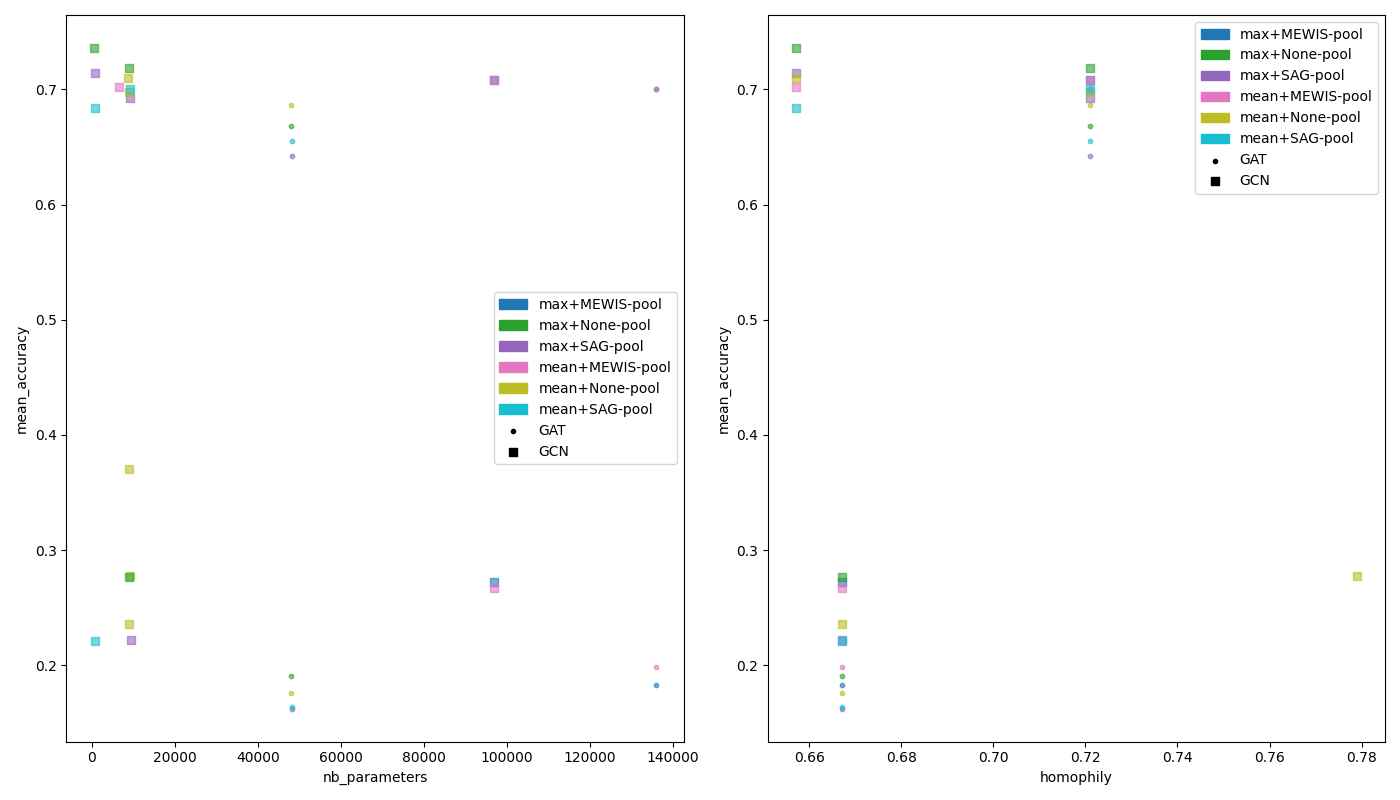

In [13]:
pairplot_from_dict(list_dict, 
                   [('nb_parameters','mean_accuracy'),
                    ('homophily','mean_accuracy')],
                    (1,2),
                    figsize=(14,8),
                    alpha=0.6,
                    s=40)

In [ ]:
def plot_bar_dataset(list_dict, cmap : str = 'tab10', n_colors : int = 5, **kwargs) :

    # first, create a dictionnary whose keys are the dataset and values are
    # the list of all element from list_dict for this dataset
    data_by_dataset = {}

    for entry in list_dict:

        dataset = entry['dataset']

        if dataset not in data_by_dataset:
            data_by_dataset[dataset] = []

        data_by_dataset[dataset].append(entry)

    # the colors of the bars
    colors = [plt.get_cmap(cmap)(i) for i in range(n_colors)]

    _, axes = plt.subplots(nrows=len(data_by_dataset), ncols=1, figsize=(10, len(data_by_dataset)*5), squeeze=False)
    axes = axes.flatten()

    for ax, (dataset, records) in zip(axes, data_by_dataset.items()):

        # all different pooling methods
        pooling_methods = np.unique([record['pooling'] for record in records])
        mean_accuracies = {pol: [] for pol in pooling_methods}

        for record in records:
            pol = record['pooling']
            mean_accuracies[pol].append(record['mean_accuracy'])

        # the list of the mean accuracy for each pooling value (averaged per pooling)
        mean_accuracies = list(map(lambda l: sum(l)/len(l), mean_accuracies.values()))

        # repeating colors if there is more pooling methods than pooling
        if len(pooling_methods) > n_colors:
            colors = colors * (len(pooling_methods) // n_colors + 1)

        bars = ax.bar(pooling_methods, mean_accuracies, color=colors[:len(pooling_methods)], **kwargs)
        ax.set_title(f'Dataset: {dataset}')
        ax.set_ylabel('Mean Accuracy')
        ax.set_xlabel('Pooling Method')
        ax.set_xticks(range(len(pooling_methods)))

        for bar, acc in zip(bars, mean_accuracies):
            height = bar.get_height()
            ax.annotate(f"{acc:.3f}", (bar.get_x() + bar.get_width() / 2, height/2),
                        textcoords="offset points", xytext=(0,0),
                        ha='center', va='center', rotation=0)

    # Adjust the spacing after creating subplots
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)  # You can adjust this value as needed

    plt.show()

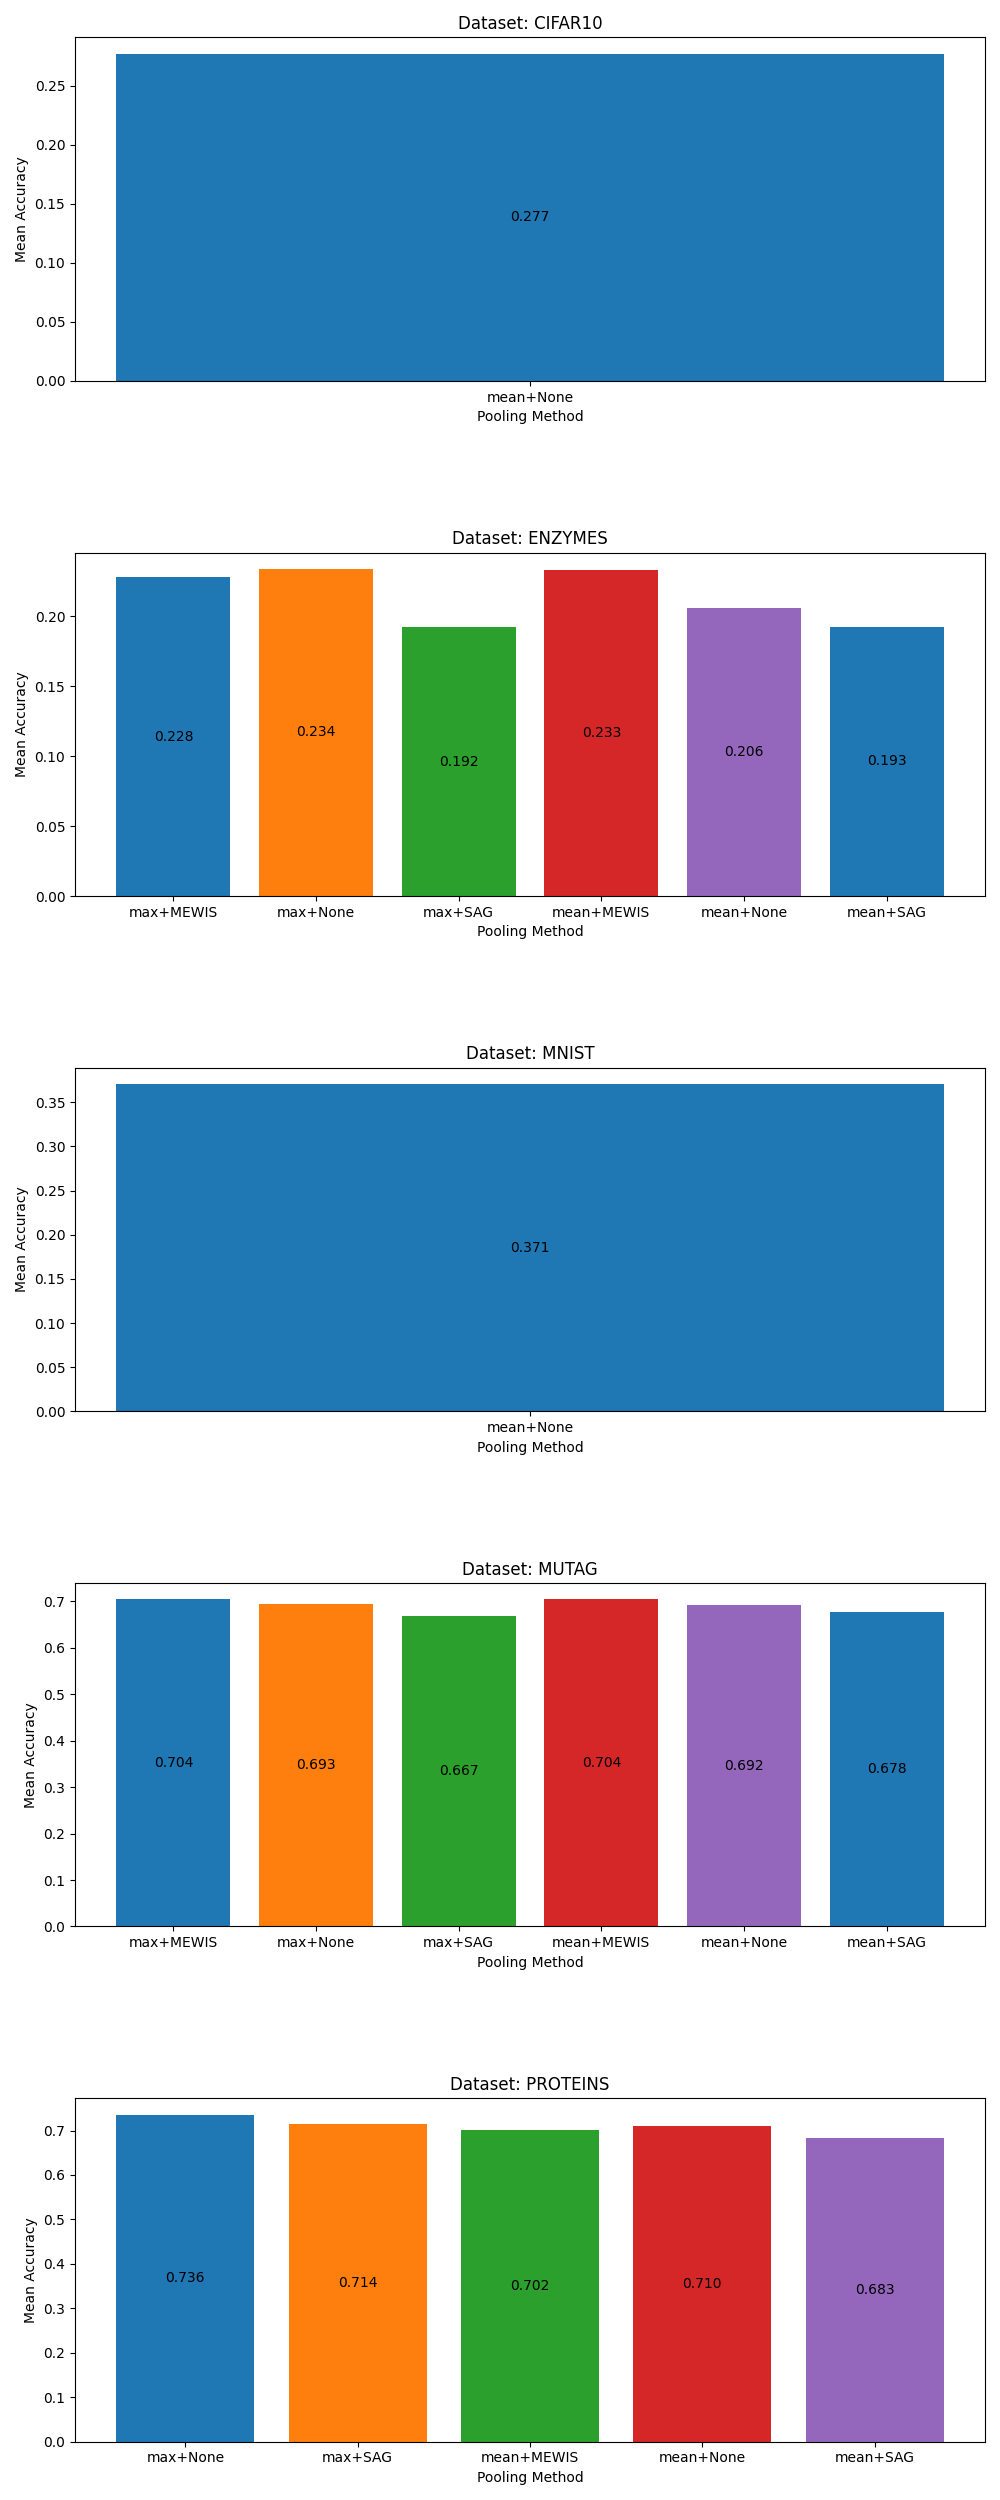

In [73]:
data = list_dict

# Organize data by dataset
data_by_dataset = {}
for entry in data:
    dataset = entry['dataset']
    if dataset not in data_by_dataset:
        data_by_dataset[dataset] = []
    data_by_dataset[dataset].append(entry)

colors = [plt.get_cmap('tab10')(i) for i in range(5)]

# Adjust figsize for better spacing or leave as is for manual adjustment later
fig, axes = plt.subplots(nrows=len(data_by_dataset), ncols=1, figsize=(10, len(data_by_dataset)*5), squeeze=False)
axes = axes.flatten()

for ax, (dataset, records) in zip(axes, data_by_dataset.items()):
    pooling_methods = np.unique([record['pooling'] for record in records])
    mean_accuracies = {pol: [] for pol in pooling_methods}

    for record in records:
        pol = record['pooling']
        mean_accuracies[pol].append(record['mean_accuracy'])

    mean_accuracies = list(map(lambda l: sum(l)/len(l), mean_accuracies.values()))

    if len(pooling_methods) > len(colors):
        colors = colors * (len(pooling_methods) // len(colors) + 1)

    bars = ax.bar(pooling_methods, mean_accuracies, color=colors[:len(pooling_methods)])
    ax.set_title(f'Dataset: {dataset}')
    ax.set_ylabel('Mean Accuracy')
    ax.set_xlabel('Pooling Method')
    ax.set_xticks(range(len(pooling_methods)))

    for bar, acc in zip(bars, mean_accuracies):
        height = bar.get_height()
        ax.annotate(f"{acc:.3f}", (bar.get_x() + bar.get_width() / 2, height/2),
                    textcoords="offset points", xytext=(0,0),
                    ha='center', va='center', rotation=0)

# Adjust the spacing after creating subplots
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # You can adjust this value as needed

plt.show()

In [11]:
poolings, color_mapping, colors = get_pooling_mapping(list_dict)
convolutions, shape_mapping, shapes = get_convolution_mapping(list_dict)

In [13]:
poolings

['mean+None',
 'max+MEWIS',
 'max+None',
 'max+SAG',
 'mean+MEWIS',
 'mean+None',
 'mean+SAG',
 'mean+None',
 'max+MEWIS',
 'max+None',
 'max+SAG',
 'mean+MEWIS',
 'mean+None',
 'mean+SAG',
 'max+None',
 'max+SAG',
 'mean+MEWIS',
 'mean+None',
 'mean+SAG']

In [14]:
convolutions = np.unique(convolutions)

In [15]:
x = np.arange(len(convolutions))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

NameError: name 'penguin_means' is not defined

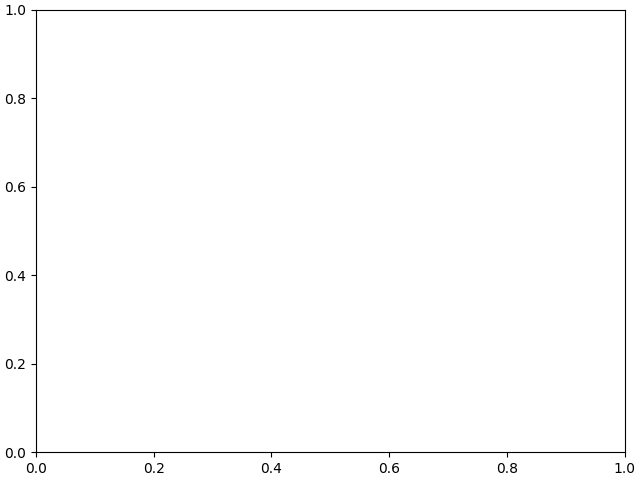

In [16]:
fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 250)

plt.show()